# Image Classification for Domestic Pets

### Authors: Jonathan Mahoney, Katie Geary, Meghan Cooke, Srujan Vithalani

#### Set Up for local

In [ ]:
#%pip install matplotlib sklearn pandas scikit-image

In [ ]:
import torchvision as thv
import torch
import cv2 
import PIL.Image 
from torchvision import models
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Compose, RandomCrop, Resize, Normalize
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.datasets import ImageFolder
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from skimage import io, color
import os
from google.colab import drive

Checking if GPU is available to use CUDA

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#need to load data here and format as tensors for training
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Data/"

archive.zip  IMG_0854.jpg  IMG_2765.jpg  IMG_7743.HEIC.jpg  peri_pic.jpg


In [ ]:
!ls

drive  sample_data


In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/Data/archive" 

Streaming output truncated to the last 5000 lines.
  inflating: images/Images/n02108089-boxer/n02108089_11687.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n021

## Image Transformation

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = ImageFolder('./images/Images', transform=transform)

In [ ]:
len(dataset)

20580

In [ ]:
len(dataset.classes)

120

In [ ]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

In [ ]:
print(breeds)

['Chihuahua', 'Japanese spaniel', 'Maltese dog', 'Pekinese', 'Shih Tzu', 'Blenheim spaniel', 'papillon', 'toy terrier', 'Rhodesian ridgeback', 'Afghan hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black and tan coonhound', 'Walker hound', 'English foxhound', 'redbone', 'borzoi', 'Irish wolfhound', 'Italian greyhound', 'whippet', 'Ibizan hound', 'Norwegian elkhound', 'otterhound', 'Saluki', 'Scottish deerhound', 'Weimaraner', 'Staffordshire bullterrier', 'American Staffordshire terrier', 'Bedlington terrier', 'Border terrier', 'Kerry blue terrier', 'Irish terrier', 'Norfolk terrier', 'Norwich terrier', 'Yorkshire terrier', 'wire haired fox terrier', 'Lakeland terrier', 'Sealyham terrier', 'Airedale', 'cairn', 'Australian terrier', 'Dandie Dinmont', 'Boston bull', 'miniature schnauzer', 'giant schnauzer', 'standard schnauzer', 'Scotch terrier', 'Tibetan terrier', 'silky terrier', 'soft coated wheaten terrier', 'West Highland white terrier', 'Lhasa', 'flat coated retriever', 'cur

In [ ]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
train_size = len(dataset) - test_size

In [ ]:
train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(14406, 6174)

In [ ]:
print(train_ds[0][1])

94


17
redbone


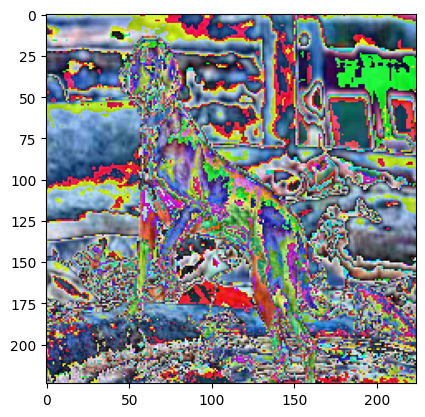

In [ ]:
img, label = train_ds[6]
print(label)
plt.imshow(transforms.ToPILImage()(img))
print(breeds[label])

## Model Setup

In [ ]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier[-1].requires_grad = True

# Replace the last fully connected layer with a new one
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, 120)

model = model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 333MB/s]


## Training

In [ ]:
EPOCHS = 15
batch_size = 64
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
print(device)

cuda


In [ ]:
train_X = torch.stack([train_ds[i][0] for i in range(len(train_ds))])

In [ ]:
train_y = torch.tensor([train_ds[i][1] for i in range(len(train_ds))])

In [ ]:
print(train_X.size())

torch.Size([14406, 3, 224, 224])


In [ ]:
trainDataSet = TensorDataset(train_X.to(device),train_y.to(device))

In [ ]:
train_loader = DataLoader(trainDataSet, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
def Train(model, loader, optimizer, criterion):
  epoch_loss = []
  epoch_acc = 0

  model.train()
  for data, labels in loader:
    optimizer.zero_grad()

    output = model(data)
    
    loss = criterion(output, labels)
    epoch_loss.append(loss.item())
    
    _, preds = torch.max(output.data, 1)
    epoch_acc += torch.sum(preds == labels.data)

    loss.backward()
    optimizer.step()
    
  return np.mean(epoch_loss), epoch_acc / len(loader.dataset)

In [ ]:
def evaluate(model, loader, criterion, test=False):
  epoch_loss = []
  epoch_acc = 0
  predicted, expected = [], []

  model.eval()
  with torch.no_grad():
    for data, labels in loader:

      output = model(data)

      loss = criterion(output, labels)
      epoch_loss.append(loss.item())
      
      _, preds = torch.max(output.data, 1)
      epoch_acc += torch.sum(preds == labels.data)

      predicted.append(preds)
      expected.append(labels)

  if test:
    expected = np.array(torch.cat(expected).cpu(), dtype=float)
    predicted = np.array(torch.cat(predicted).cpu(), dtype=float)
    precision, recall, fscore, _ = precision_recall_fscore_support(expected, predicted, average='macro')
    accuracy = accuracy_score(expected, predicted)
    print('Scores:')
    print(f'Precision: {precision}, Recall: {recall}, Fscore: {fscore}, Accuracy: {accuracy}')

  return predicted, expected

In [ ]:
train_loss = []
train_acc = []

for epoch in range(EPOCHS):
  trainEpochLoss, trainEpochAcc = Train(model, train_loader, optimizer, criterion)
  train_loss.append(trainEpochLoss)
  train_acc.append(trainEpochAcc)
  print(f'Epoch: {epoch} Train Loss: {trainEpochLoss} Train Acc: {trainEpochAcc}')

Epoch: 0 Train Loss: 2.3458940643734403 Train Acc: 0.5236707329750061
Epoch: 1 Train Loss: 0.9578899192810059 Train Acc: 0.7843953967094421
Epoch: 2 Train Loss: 0.7193960449430677 Train Acc: 0.8163265585899353
Epoch: 3 Train Loss: 0.6159605638186136 Train Acc: 0.8334721922874451
Epoch: 4 Train Loss: 0.5495177931255765 Train Acc: 0.8447175025939941
Epoch: 5 Train Loss: 0.5028347421354717 Train Acc: 0.8565181493759155
Epoch: 6 Train Loss: 0.46394759131802454 Train Acc: 0.8665834069252014
Epoch: 7 Train Loss: 0.42896281050311197 Train Acc: 0.8708177804946899
Epoch: 8 Train Loss: 0.41171207202805415 Train Acc: 0.875607430934906
Epoch: 9 Train Loss: 0.38624127745628356 Train Acc: 0.8859503269195557
Epoch: 10 Train Loss: 0.3725310433573193 Train Acc: 0.8858115077018738
Epoch: 11 Train Loss: 0.35520318534639145 Train Acc: 0.8921282887458801
Epoch: 12 Train Loss: 0.33788321210278405 Train Acc: 0.8976815342903137
Epoch: 13 Train Loss: 0.32407938679059345 Train Acc: 0.9007358551025391
Epoch: 14 

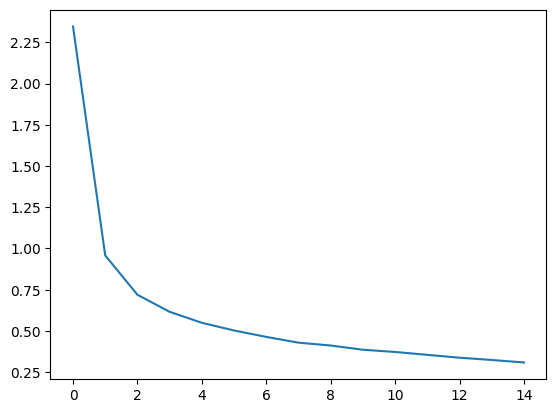

In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.show()

In [ ]:
cpu_train_arr = [tensor.detach().cpu().numpy() for tensor in train_acc]

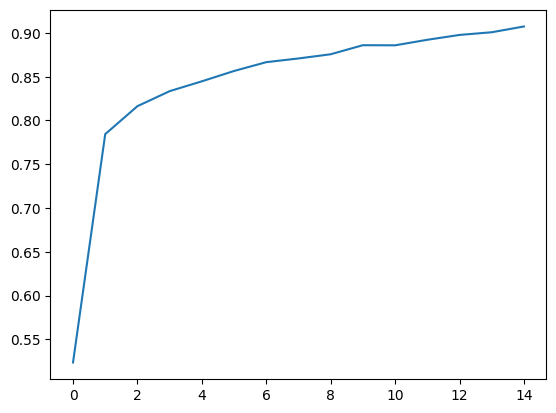

In [ ]:
plt.plot(cpu_train_arr, label='Train Acc')
plt.show()

## Validation

In [ ]:
testX = torch.stack([test_ds[i][0] for i in range(len(test_ds))])
testY = torch.tensor([test_ds[i][1] for i in range(len(test_ds))])

In [ ]:
test_data = TensorDataset(testX.to(device), testY.to(device))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
predicted, expected = evaluate(model, test_loader, criterion, test=True)

Scores:
Precision: 0.849941905648914, Recall: 0.8481151723415409, Fscore: 0.8455276796381124, Accuracy: 0.8512369791666666


## Predict Dogs

In [ ]:
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = PIL.Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = transform(img).float()
    img = img.unsqueeze(0)  # Add batch size for PyTorch: [1, 3, 224, 224]
    model.cpu()
    _, preds = torch.max(model(img), 1)
    return breeds[preds]

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Data/"

archive.zip   IMG_2765.jpg  lp_image.jpg
IMG_0854.jpg  IMG_7743.jpg  peri_pic.jpg


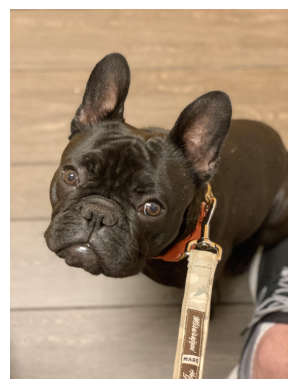

'French bulldog'

In [ ]:
predict_breed_transfer("/content/drive/My Drive/Colab Notebooks/Data/peri_pic.jpg")

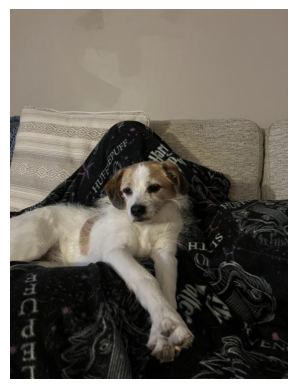

'English setter'

In [ ]:
predict_breed_transfer("/content/drive/My Drive/Colab Notebooks/Data/IMG_0854.jpg")

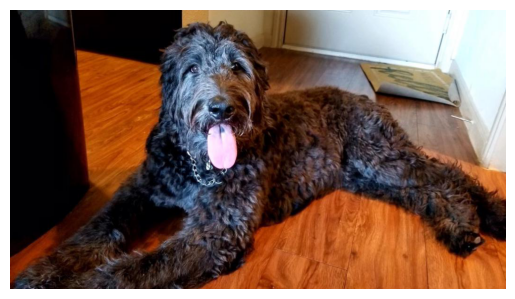

'briard'

In [ ]:
predict_breed_transfer("/content/drive/My Drive/Colab Notebooks/Data/IMG_2765.jpg")

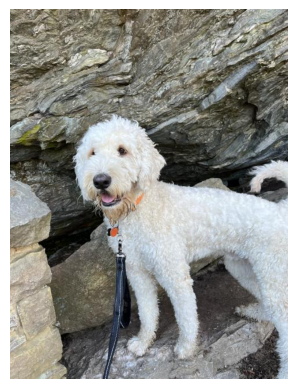

'Old English sheepdog'

In [ ]:
predict_breed_transfer("/content/drive/My Drive/Colab Notebooks/Data/IMG_7743.jpg")

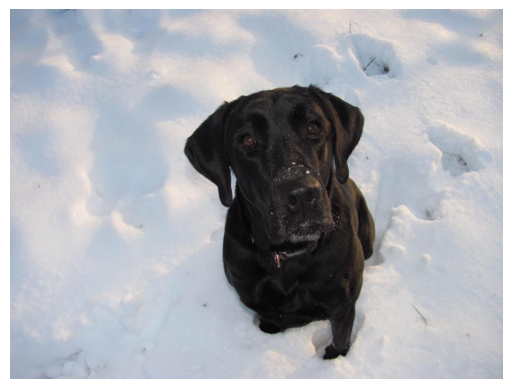

'Labrador retriever'

In [ ]:
predict_breed_transfer("/content/drive/My Drive/Colab Notebooks/Data/IMG_3007.JPG")

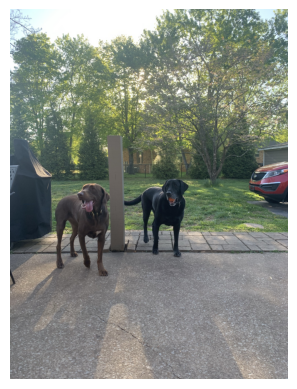

'Labrador retriever'

In [ ]:
predict_breed_transfer("/content/drive/My Drive/Colab Notebooks/Data/IMG_8119.JPEG"

In [ ]:
predict_breed_transfer("/content/drive/My Drive/Colab Notebooks/Data/IMG_8748.JPEG")

'cocker spaniel'

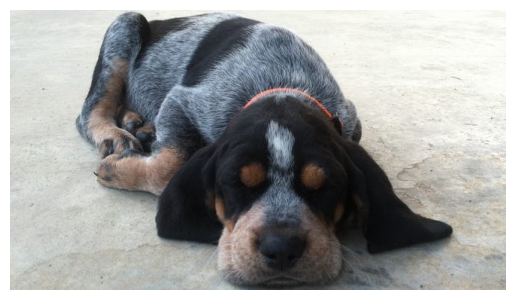

'bluetick'

In [ ]:
predict_breed_transfer("/content/drive/My Drive/Colab Notebooks/Data/IMG_8934.JPG")

## Human Detection and which Dog Breed

In [ ]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/Data/haarcascade_frontalface_alt.xml')

# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [ ]:
def what_am_i(img_path):
  #figure out if its a human or dog
  isHuman = face_detector(img_path)
  if isHuman:
    print(f'Human Detected! You look like a {predict_breed_transfer(img_path)}')
  else:
    print(f'Dog Detected! Dog Breed: {predict_breed_transfer(img_path)}')

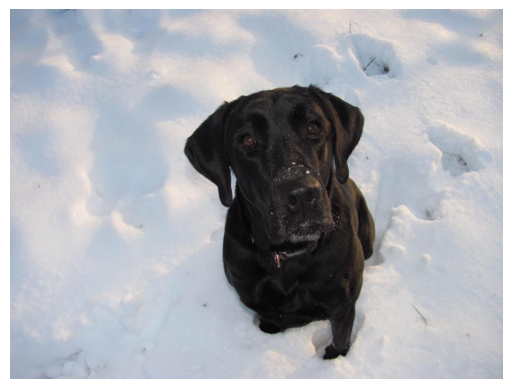

Dog Detected! Dog Breed: Labrador retriever


In [ ]:
what_am_i("/content/drive/My Drive/Colab Notebooks/Data/IMG_3007.JPG")

In [ ]:
what_am_i("/content/drive/My Drive/Colab Notebooks/Data/IMG-0376.jpg")

Human Detected! You look like a Weimaraner



<img src="http://t3.gstatic.com/licensed-image?q=tbn:ANd9GcTW4PxJMmqKX-iGS1zCBki9xALaex4zaWFeyd1qDBkJwwzOGVyvx_dukVn6ieZBaodi2OOJ-PmXd_Y_JXI" alt="Weimaraner" style="max-height: 200px"/>

In [ ]:
what_am_i("/content/drive/My Drive/Colab Notebooks/Data/IMG_5598.jpg")

Human Detected! You look like a Lhasa


![Lhasa](http://t3.gstatic.com/licensed-image?q=tbn:ANd9GcQFr7RCTHpBPAK98aYb8FhUbmKtu1auATISMhscv6wc4u9hvfLBoWsai99zKVzIntt5Gwu50aCe2qQkwUM)

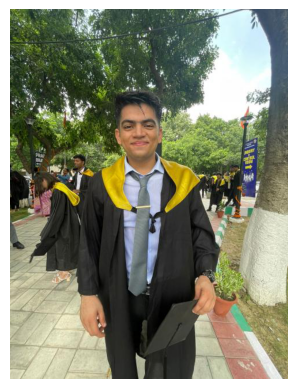

Human Detected! You look like a Sussex spaniel


In [ ]:
what_am_i("/content/drive/My Drive/Colab Notebooks/Data/srujan.jpg")

![sussex spaniel](http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcQtQs28TvIeQm7ae9wFo1uu1zNiBYUKe8nRpxZY3hhvLP1E_paew00VlO7e30sC7L0H5gcEpVQvi6YWJAs)

In [ ]:
what_am_i("/content/drive/My Drive/Colab Notebooks/Data/meghan.jpg")

Human Detected! You look like a Maltese dog


![Maltese](http://t3.gstatic.com/licensed-image?q=tbn:ANd9GcSsylM0lFatrYrQw2bLLxFvfKdYjn8rtjBGopD9vDUZvmcq29vdgALuY5-b2GX0YYcJCNBKQKgn-VJo0_c)

In [ ]:
what_am_i("/content/drive/My Drive/Colab Notebooks/Data/image0000.jpg")

Human Detected! You look like a Italian greyhound


<img src="http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcT_2zBmCWRFPGGnBkdjwFyjpKB21Ta525P6esz19fChFsencLFSptaCF3gRmse5TXEkp0zcMZZEOaw-5qc"/>

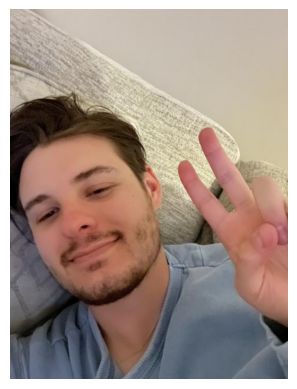

Dog Detected! Dog Breed: Maltese dog


In [ ]:
what_am_i("/content/drive/My Drive/Colab Notebooks/Data/IMG_1023.jpg")

![Maltese](http://t3.gstatic.com/licensed-image?q=tbn:ANd9GcSsylM0lFatrYrQw2bLLxFvfKdYjn8rtjBGopD9vDUZvmcq29vdgALuY5-b2GX0YYcJCNBKQKgn-VJo0_c)

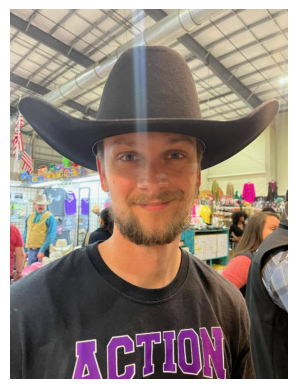

Human Detected! You look like a Chihuahua


In [ ]:
what_am_i("/content/drive/My Drive/Colab Notebooks/Data/IMG_3919.jpg")

<img src="https://1.bp.blogspot.com/-O_mJklq1r_E/Vf8WoetpM8I/AAAAAAAAfw4/Boqzt3soFI0/s1600/king5.jpg"/>

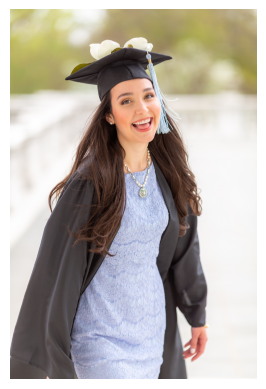

Human Detected! You look like a Saluki


In [ ]:
what_am_i("/content/drive/My Drive/Colab Notebooks/Data/IMG_2178.jpeg")

<img src="https://www.purina.co.uk/sites/default/files/styles/square_medium_440x440/public/2022-08/Saluki1.jpg?h=7952e849&itok=e11g-uO-"/>